In [22]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [5]:
# Set random seed for reproducibility
np.random.seed(13)

# Generate synthetic data
n = 1500  # Number of samples per group

# Group A: 11% conversion rate
group_a = np.random.choice(['converted', 'not converted'], size=n, p=[0.11, 0.89])

# Group B: 17% conversion rate (we expect this to perform better)
group_b = np.random.choice(['converted', 'not converted'], size=n, p=[0.17, 0.83])

# Create a DataFrame
df = pd.DataFrame({
    'group': ['A'] * n + ['B'] * n,
    'converted': [1 if x == 'converted' else 0 for x in group_a] + 
                 [1 if x == 'converted' else 0 for x in group_b]
})

In [6]:
df.head()

,group,converted
0,A,0
1,A,0
2,A,0
3,A,0
4,A,0


In [7]:
# Check basic statistics
print(df.groupby('group').describe())

      converted                                             
          count      mean       std  min  25%  50%  75%  max
group                                                       
A        1500.0  0.114667  0.318726  0.0  0.0  0.0  0.0  1.0
B        1500.0  0.159333  0.366109  0.0  0.0  0.0  0.0  1.0


## Hypotheses

**Null Hypothesis (H₀):**  
`p_A - p_B = 0`  
No difference in conversion rates between groups

**Alternative Hypothesis (H₁):**  
`p_A - p_B ≠ 0`  
Conversion rates are significantly different

*α = 0.05, Two-tailed test*

In [8]:
## Using stats library repeat the steps 
# Extract the number of successes and sample sizes
success_a = df[df['group'] == 'A']['converted'].sum()
size_a = len(df[df['group'] == 'A'])

success_b = df[df['group'] == 'B']['converted'].sum()
size_b = len(df[df['group'] == 'B'])

# Calculate the z-score and p-value
from statsmodels.stats.proportion import proportions_ztest

count = np.array([success_a, success_b])
nobs = np.array([size_a, size_b])

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the groups.")

Z-statistic: -3.5575
P-value: 0.0004
Reject the null hypothesis: There is a significant difference between the groups.


## Randomization Test: Another Way to Determine the Significance of A/B Testing

**Steps:**

1. **Combine** group A and B data, then random darw new groups A and B, then measure the different conversion rate for each.
2. **Repeat** the step 1 for multiple times, eg 1000 times resampling, records the conversion rate difference for each time.
3. **Plot** the hisgram of 1000 resample tests with the conversion rate different then compare it with the orgianal rate difference 

In [14]:
df[df['group'] == 'A'].converted.value_counts()

converted
0    1328
1     172
Name: count, dtype: int64

In [15]:
df[df['group'] == 'B'].converted.value_counts()

converted
0    1261
1     239
Name: count, dtype: int64

In [16]:
obs_pct_diff = 100 * (239/1500 - 172/1500)
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: 4.4667%


In [17]:
conversion = [0] * (1328+1261)
conversion.extend([1] * (172+239))
conversion = pd.Series(conversion)

In [39]:
def perm_fun(x, nA, nB):
    n = nA + nB
    # Convert to list instead of set for pandas indexing
    idx_B = random.sample(range(n), nB)
    # Create idx_A as a list of elements not in idx_B
    idx_A = [i for i in range(n) if i not in idx_B]
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()


perm_diffs = [100 * perm_fun(conversion, 1500, 1500) for i in range(1000)]

Text(0, 0.5, 'Frequency')

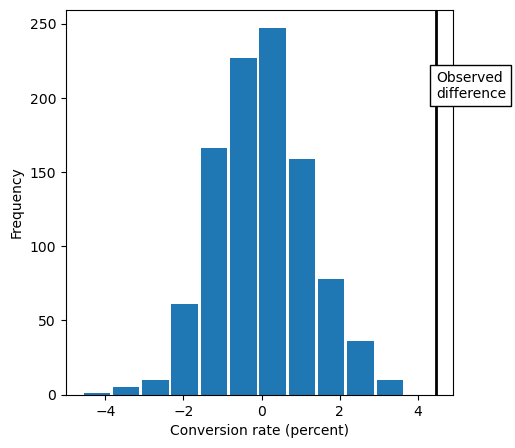

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(obs_pct_diff, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

## 🎯 Conclusion

- **Statistical distribution**: the rate difference range from -4.5 to 3.5 (appoximately) , and the oberved difference is out of this variance distribution.
- **Interpretation**: the statistically significant difference was found between Group A and Group B
- **Decision**: reject the null hypothesis (same conclusion as p-value test)
- **“Comparing the observed value of the statistic to the resampled distribution allows you to judge whether an observed difference between samples might occur by chance."** -- Practical Statistics for Data Scientists, 2nd Edition (Peter Gedeck)
